In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.feature_selection import RFECV, VarianceThreshold
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler
from scipy import stats
import warnings

# ignore warnings to keep output clean
warnings.filterwarnings('ignore')



## 1. Load Data


In [2]:
print("Loading data...")

df = pd.read_csv("Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")




Loading data...


## 2. Preprocessing


In [3]:
print("\nStarting Preprocessing...")

# Step 1: Fix Column Names
print("1. Formatting Column Names...")
df.columns = df.columns.str.strip()

# Step 2: Handle Inf and NaN
print('--------------------------')
print( df.isin([np.inf, -np.inf]).sum())
print('--------------------------')
print("2. Handling Inf & NaN...")
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Step 3: Remove Duplicates
print("3. Removing Duplicates...")
before = len(df)
df.drop_duplicates(inplace=True)
print(f"Removed {before - len(df)} duplicate rows")

# Step 4: Fix Data Types
print("4. Data Type Correction...")
exclude_cols = ['Flow ID', 'Source IP', 'Destination IP', 'Timestamp', 'SimillarHTTP']
for col in df.columns:
    if col in exclude_cols:
        continue
    
    if col != 'Label' and df[col].dtype == 'object':
        try:
            # Try converting to numbers
            numeric_col = pd.to_numeric(df[col], errors='coerce')
            # If mostly numbers (less than 10% errors), perform conversion
            if numeric_col.isna().sum() < 0.1 * len(df):
                df[col] = numeric_col
                print(f"   Converted {col} to numeric")
        except:
            pass

# Drop any rows that became NaN after conversion
df.dropna(inplace=True)

# Step 5: Encode Label
print("5. Label Encoding...")
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'].astype(str))
print("Label encoded.")
df.head()



Starting Preprocessing...
1. Formatting Column Names...
--------------------------
Flow ID             0
Source IP           0
Source Port         0
Destination IP      0
Destination Port    0
                   ..
Idle Mean           0
Idle Std            0
Idle Max            0
Idle Min            0
Label               0
Length: 85, dtype: int64
--------------------------
2. Handling Inf & NaN...
3. Removing Duplicates...
Removed 2 duplicate rows
4. Data Type Correction...
5. Label Encoding...
Label encoded.


,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.5-104.16.207.165-54865-443-6,104.16.207.165,443,192.168.10.5,54865,6,7/7/2017 3:30,3,2,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
1,192.168.10.5-104.16.28.216-55054-80-6,104.16.28.216,80,192.168.10.5,55054,6,7/7/2017 3:30,109,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
2,192.168.10.5-104.16.28.216-55055-80-6,104.16.28.216,80,192.168.10.5,55055,6,7/7/2017 3:30,52,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
3,192.168.10.16-104.17.241.25-46236-443-6,104.17.241.25,443,192.168.10.16,46236,6,7/7/2017 3:30,34,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
4,192.168.10.5-104.19.196.102-54863-443-6,104.19.196.102,443,192.168.10.5,54863,6,7/7/2017 3:30,3,2,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0


## 3. Feature Cleaning


In [4]:
print("\nFeature Cleaning...")

# Separate Features (X) and Target (y)
X = df.drop('Label', axis=1)
y = df['Label']


# Columns to skip (Identifiers)
exclude_cols = ['Flow ID', 'Source IP', 'Destination IP', 'Timestamp', 'SimillarHTTP']
for col in exclude_cols:
    if col in X.columns:
        X = X.drop(col, axis=1)
print(f"   Dropped identifiers: {exclude_cols}")


print("6. Feature cleaning will be done after train/test split ")
X.head()



Feature Cleaning...
   Dropped identifiers: ['Flow ID', 'Source IP', 'Destination IP', 'Timestamp', 'SimillarHTTP']
6. Feature cleaning will be done after train/test split 


,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,443,54865,6,3,2,0,12,0,6,6,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
1,80,55054,6,109,1,1,6,6,6,6,...,0,20,0.0,0.0,0,0,0.0,0.0,0,0
2,80,55055,6,52,1,1,6,6,6,6,...,0,20,0.0,0.0,0,0,0.0,0.0,0,0
3,443,46236,6,34,1,1,6,6,6,6,...,0,20,0.0,0.0,0,0,0.0,0.0,0,0
4,443,54863,6,3,2,0,12,0,6,6,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0


## 4. Outlier Analysis


    - Bwd Packet Length Mean: 1 outliers, 100.0% are Attacks


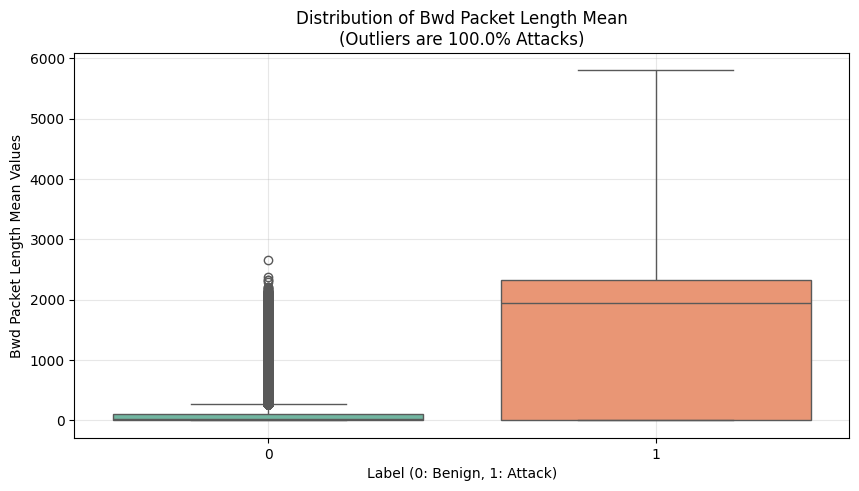

    - Bwd Packet Length Std: 299 outliers, 100.0% are Attacks


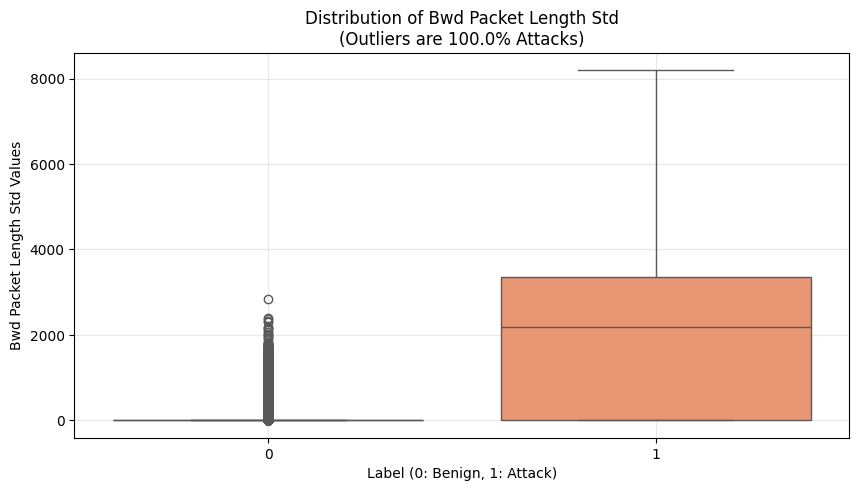

    - Flow IAT Std: 1966 outliers, 73.1% are Attacks


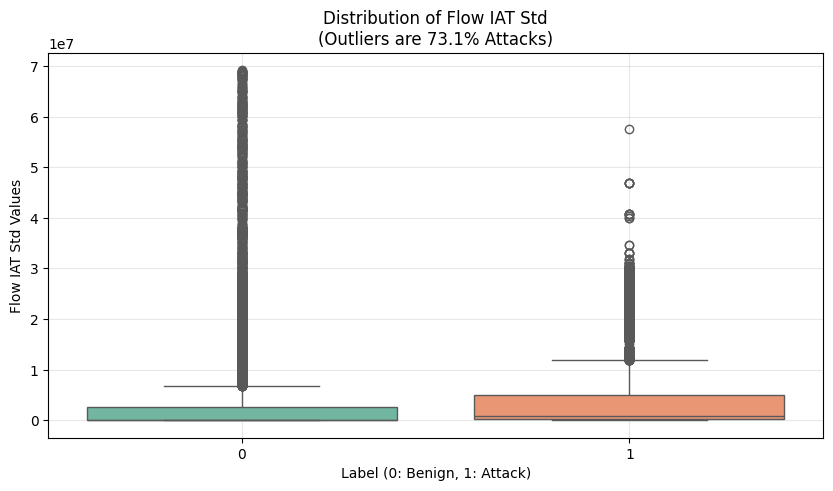

    - Flow IAT Max: 2933 outliers, 65.3% are Attacks


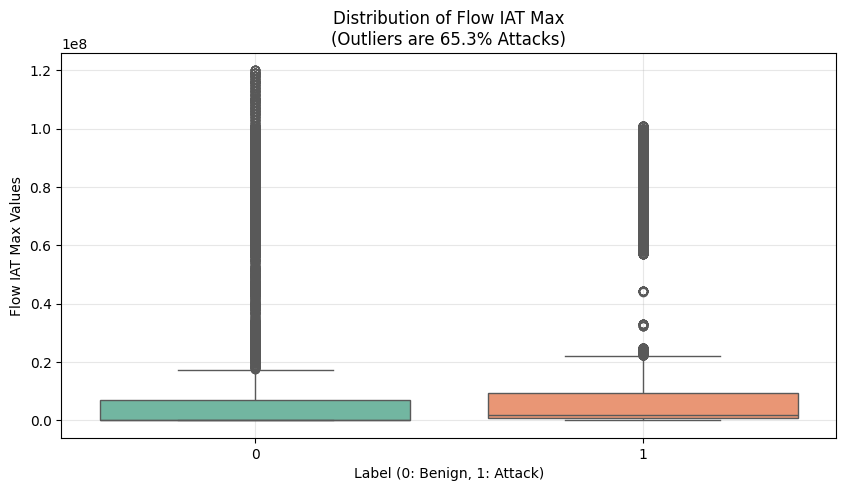

    - Packet Length Variance: 6908 outliers, 91.2% are Attacks


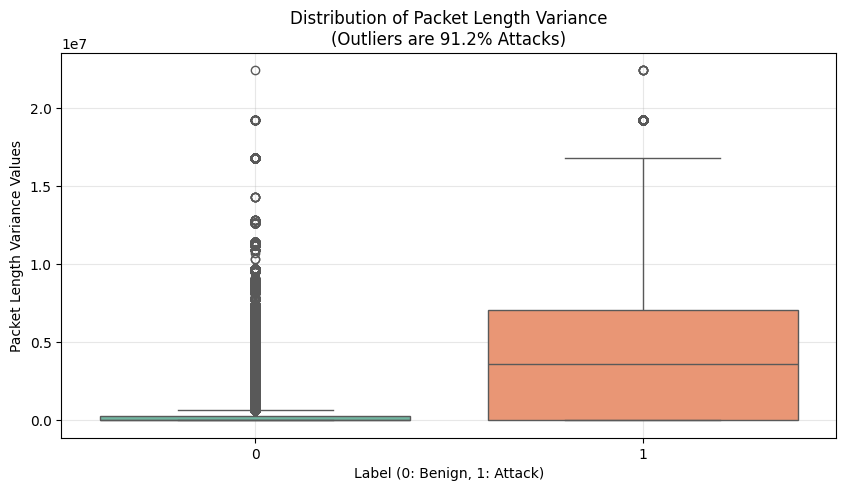

    - Avg Bwd Segment Size: 1 outliers, 100.0% are Attacks


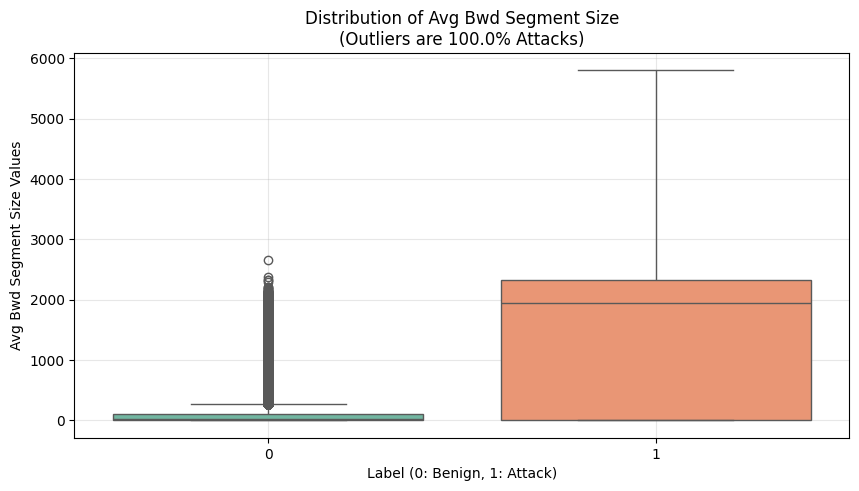

    - Active Mean: 7098 outliers, 65.2% are Attacks


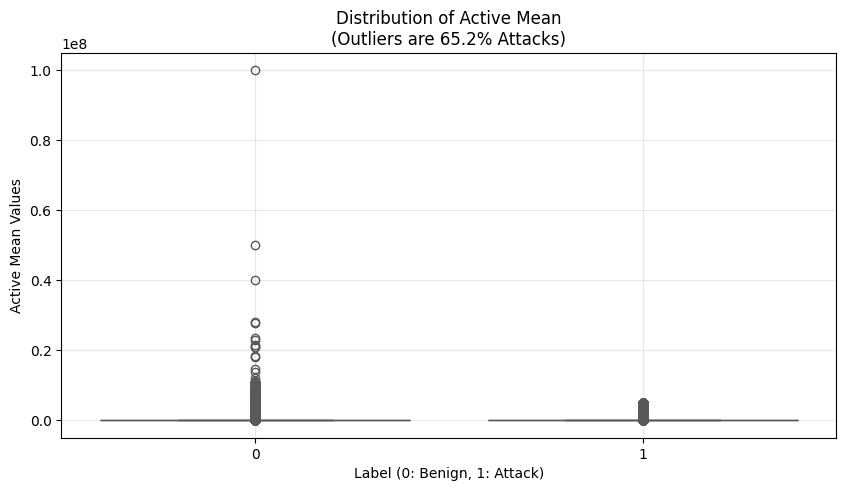

    - Active Max: 6876 outliers, 59.7% are Attacks


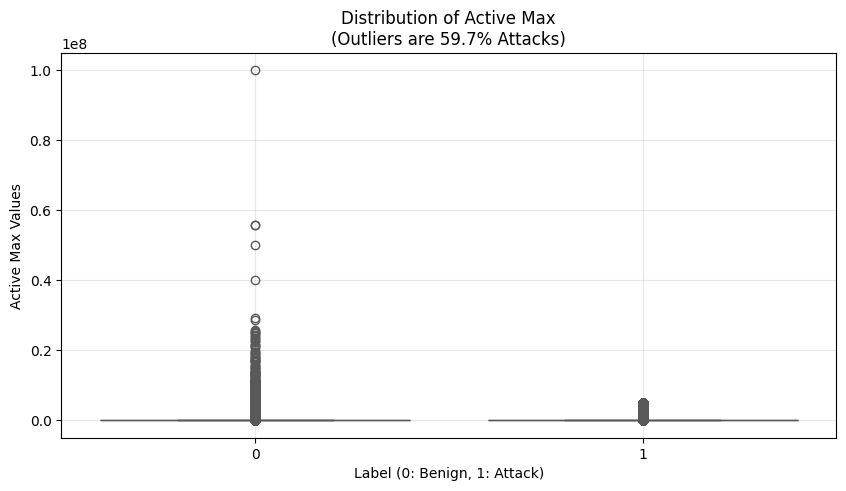

    - Active Min: 7083 outliers, 66.3% are Attacks


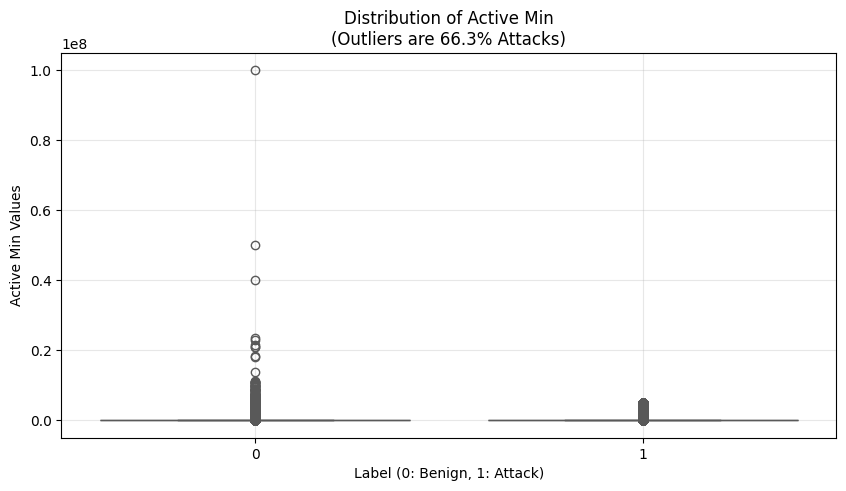

    - Idle Mean: 9757 outliers, 70.1% are Attacks


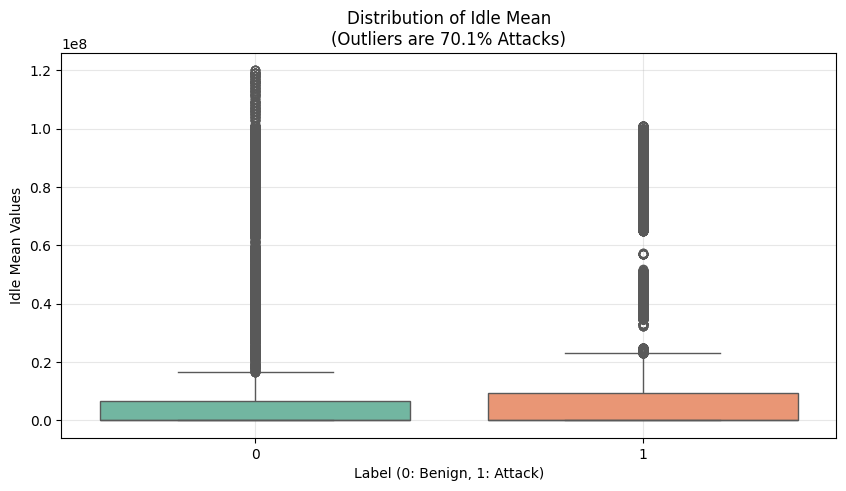

    - Idle Std: 12812 outliers, 70.9% are Attacks


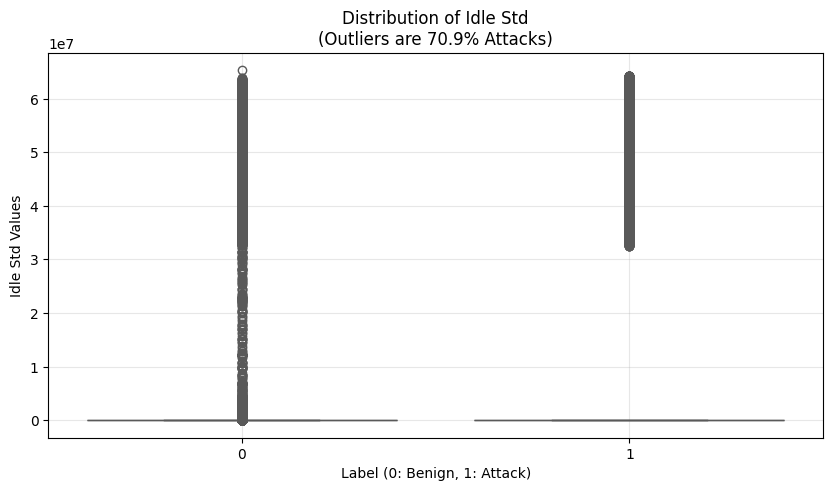

    - Idle Max: 2908 outliers, 65.9% are Attacks


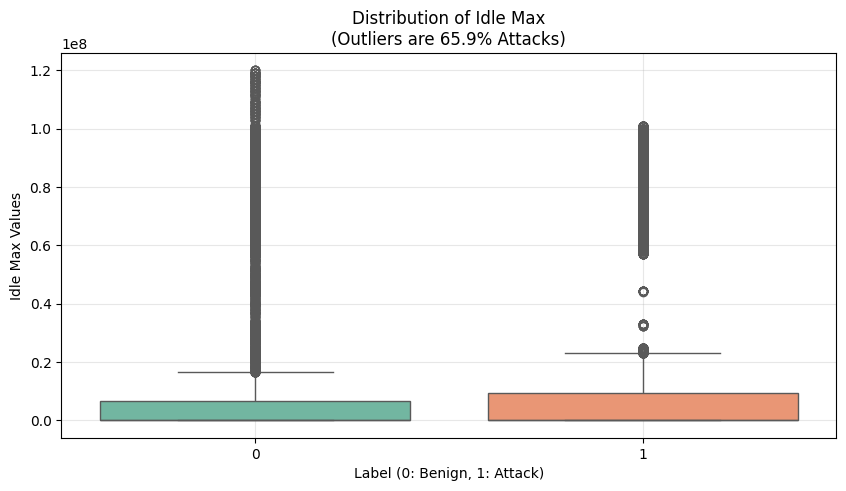

    - Idle Min: 13013 outliers, 70.5% are Attacks


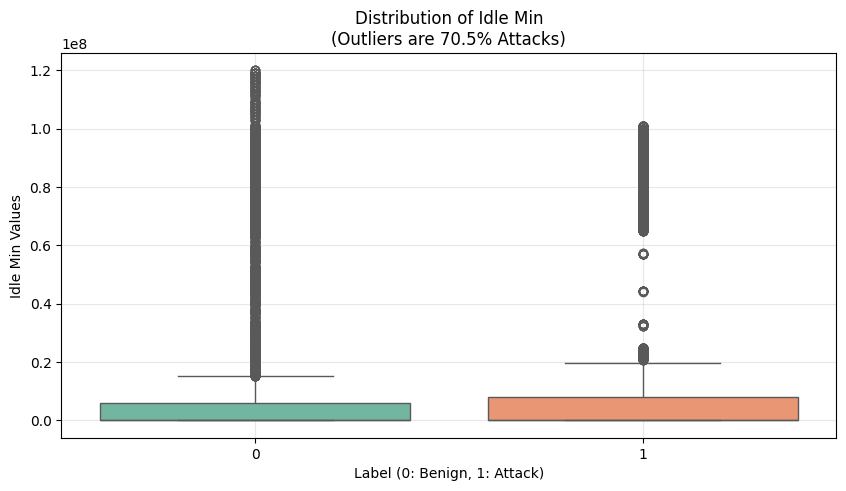

In [5]:
# We just want to see if outliers are actually attacks
numerical_cols = X.select_dtypes(include=[np.number]).columns
found_significant = False

for col in numerical_cols:
    try:
        # Calculate Z-score
        z_scores = np.abs(stats.zscore(X[col]))
        # Consider Z > 3 as outlier
        outliers_mask = z_scores > 3
        
        if outliers_mask.any():
            # Check labels of these outliers
            outlier_labels = y[outliers_mask]
            # Count attacks (assuming 1 = Attack)
            attack_count = (outlier_labels == 1).sum()
            total_outliers = outliers_mask.sum()
            percentage = (attack_count / total_outliers) * 100
            
            if percentage > 50:
                print(f"    - {col}: {total_outliers} outliers, {percentage:.1f}% are Attacks")
                found_significant = True

                plt.figure(figsize=(10, 5))
                sns.boxplot(x=y, y=X[col], palette="Set2")
                plt.title(f'Distribution of {col}\n(Outliers are {percentage:.1f}% Attacks)')
                plt.xlabel('Label (0: Benign, 1: Attack)')
                plt.ylabel(f'{col} Values')
                plt.grid(True, alpha=0.3)
                plt.show()
    except:
        continue

if not found_significant:
    print(" No strong relation found")



## 5. Split Data


In [6]:
print(" Splitting Data")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"   Training shape before feature cleaning: {X_train.shape}")

# 5.5 Remove Constant Features data leakage
# ==========================================
print("\n7.5 Removing Constant Features (on train only)")
selector = VarianceThreshold(threshold=0)
selector.fit(X_train)  

X_train = X_train.loc[:, selector.get_support()]
X_test = X_test.loc[:, selector.get_support()]  
print(f"   Shape after removing constant features: {X_train.shape}")





 Splitting Data
   Training shape before feature cleaning: (157996, 80)

7.5 Removing Constant Features (on train only)
   Shape after removing constant features: (157996, 70)


In [7]:
# Remove High Correlation 
# ==========================================
print("7.6 Removing Highly Correlated Features (on train only)...")
corr_matrix = X_train.corr().abs()  
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find features with correlation > 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X_train = X_train.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)  
print(f"   Dropped {len(to_drop)} redundant features.")
print(f"  Final shape: {X_train.shape}")


7.6 Removing Highly Correlated Features (on train only)...
   Dropped 26 redundant features.
  Final shape: (157996, 44)


## 6. Scaling (RobustScaler)


In [8]:
print("8. Feature Scaling (Using RobustScaler for Outliers)...")
# Using RobustScaler because we have outliers that are real attacks
scaler = RobustScaler(quantile_range=(25, 75))

# Fit and transform Train
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
# Transform Test
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
X_train_scaled.head()


8. Feature Scaling (Using RobustScaler for Outliers)...


,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Bwd Packet Length Max,...,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Idle Mean,Idle Std,Idle Min
0,-0.357911,0.0,0.0,1.169480,0.666667,0.000000,-0.50,1.000000,-0.102564,-0.016952,...,0.000000,-0.556522,0.666667,0.0,1.567469,0.0,1.567469,1.414248,0.0,1.569880
1,0.011022,0.0,0.0,0.295049,1.000000,0.157895,-0.50,1.000000,-0.102564,-0.016952,...,0.000000,-0.556522,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
2,0.389118,-27.0,11.0,-0.163769,-0.333333,1.368421,0.75,6.833333,1.243590,-0.004452,...,-0.032274,-0.556522,-0.333333,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
3,0.279233,0.0,0.0,0.303489,0.333333,-0.157895,-0.50,1.000000,-0.102564,-0.016952,...,0.000000,-0.556522,0.333333,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
4,0.069006,0.0,0.0,7.946418,1.666667,0.684211,0.00,0.000000,-0.064103,1.233048,...,0.000000,0.443478,1.333333,0.0,1086.288180,0.0,1086.288180,8.352524,0.0,9.271685


## 8. Feature Selection (RFECV)


In [9]:
print("\nRunning RFECV (Feature Selection)...")

# Setup XGBoost with robust parameters
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=5,           # Not too deep
    min_child_weight=3,    # Robust to noise
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

rfecv = RFECV(
    estimator=xgb, 
    step=1, 
    cv=StratifiedKFold(3), 
    scoring='accuracy',
    n_jobs=-1
)

rfecv.fit(X_train_scaled, y_train)

print(f"\nOptimal number of features: {rfecv.n_features_}")

# Save selected features list
selected_features = X_train.columns[rfecv.support_]
print("Selected Features:")
with open("result_features.txt", "w") as f:
    f.write(f"Count: {rfecv.n_features_}\n")
    for feat in selected_features:
        print(f"- {feat}")
        f.write(f"{feat}\n")





Running RFECV (Feature Selection)...

Optimal number of features: 23
Selected Features:
- Source Port
- Destination Port
- Flow Duration
- Total Fwd Packets
- Total Length of Fwd Packets
- Fwd Packet Length Max
- Fwd Packet Length Mean
- Bwd Packet Length Max
- Flow IAT Mean
- Flow IAT Std
- Fwd IAT Mean
- Fwd IAT Min
- Bwd IAT Total
- Bwd IAT Mean
- Bwd Packets/s
- Packet Length Mean
- Packet Length Variance
- URG Flag Count
- Down/Up Ratio
- Init_Win_bytes_forward
- Init_Win_bytes_backward
- act_data_pkt_fwd
- Idle Min


## 4. Visualizations



Generating Plots...


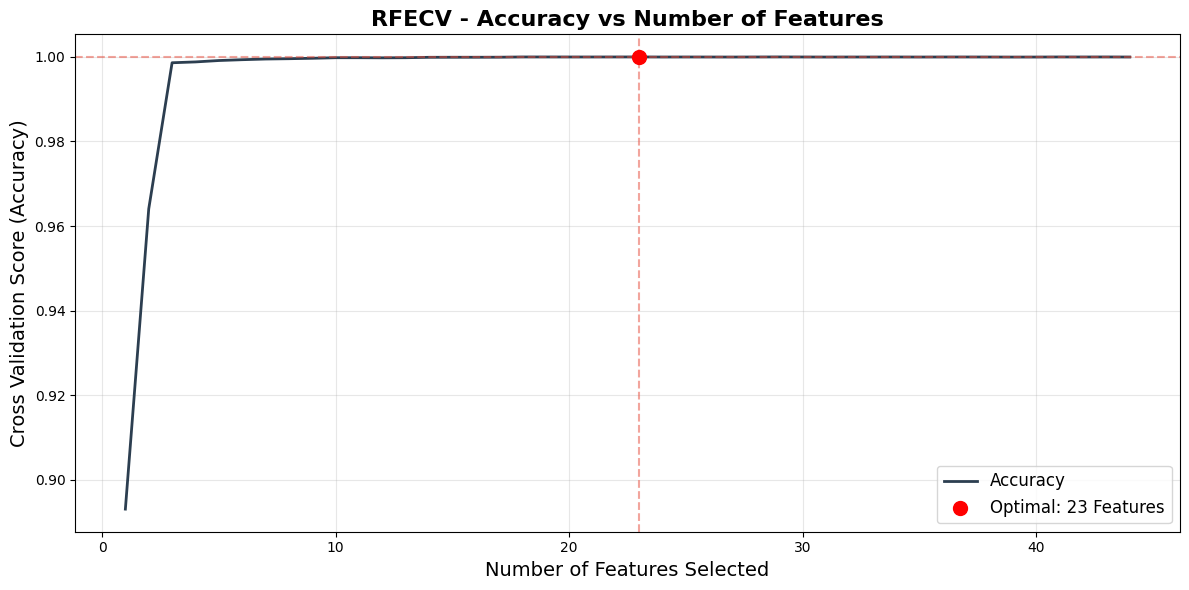

In [10]:

print("\nGenerating Plots...")


plt.figure(figsize=(12, 6))
plt.title('RFECV - Accuracy vs Number of Features', fontsize=16, fontweight='bold')
plt.xlabel('Number of Features Selected', fontsize=14)
plt.ylabel('Cross Validation Score (Accuracy)', fontsize=14)


results = rfecv.cv_results_['mean_test_score']
n_features = range(1, len(results) + 1)

plt.plot(n_features, results, color='#2c3e50', linewidth=2, label='Accuracy')


optimal_num = rfecv.n_features_
max_score = max(results)
plt.scatter(optimal_num, max_score, color='red', s=100, zorder=5, label=f'Optimal: {optimal_num} Features')


plt.axvline(x=optimal_num, color='#e74c3c', linestyle='--', alpha=0.5)
plt.axhline(y=max_score, color='#e74c3c', linestyle='--', alpha=0.5)

plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('rfe_performance_curve.png', dpi=300) 
plt.show()


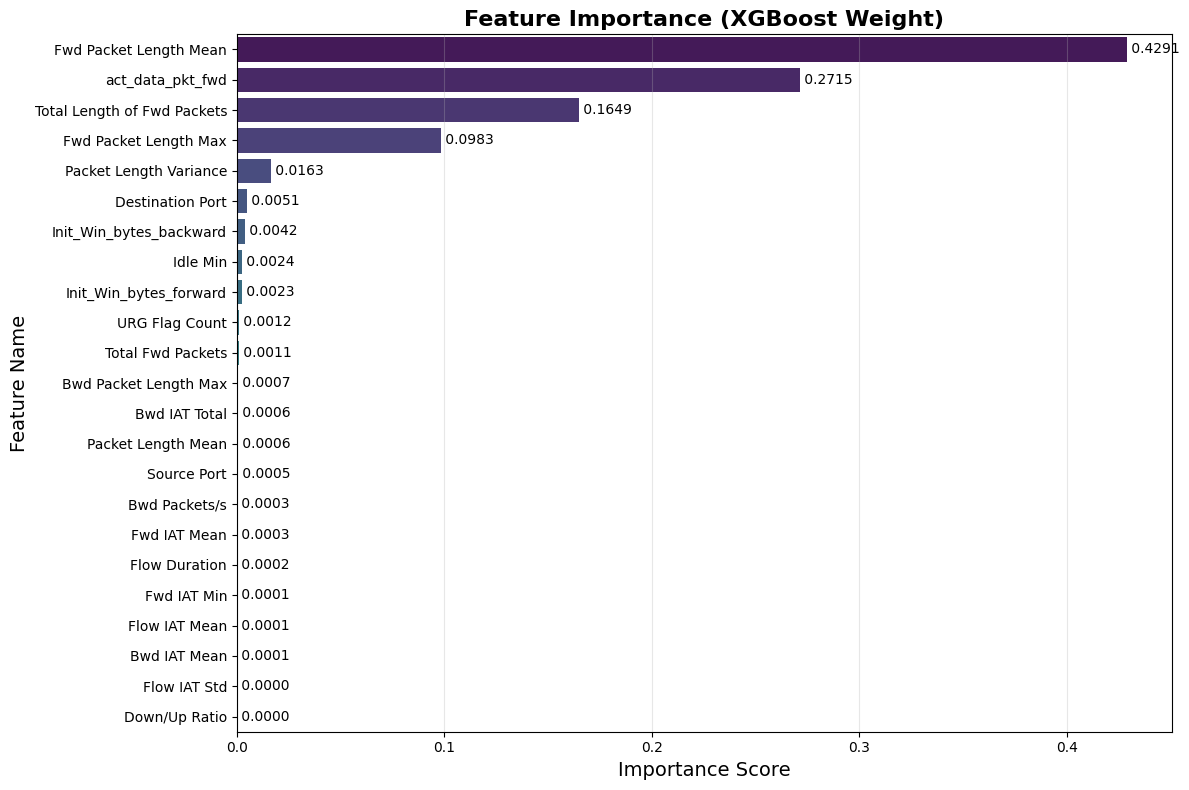

In [11]:
importances = rfecv.estimator_.feature_importances_
selected_cols = X_train.columns[rfecv.support_]


feature_imp_df = pd.DataFrame({
    'Feature': selected_cols,
    'Importance': importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))

sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')

plt.title('Feature Importance (XGBoost Weight)', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Feature Name', fontsize=14)


for i, v in enumerate(feature_imp_df['Importance']):
    plt.text(v, i, f' {v:.4f}', va='center', fontsize=10)

plt.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('feature_importance_bar.png', dpi=300)
plt.show()

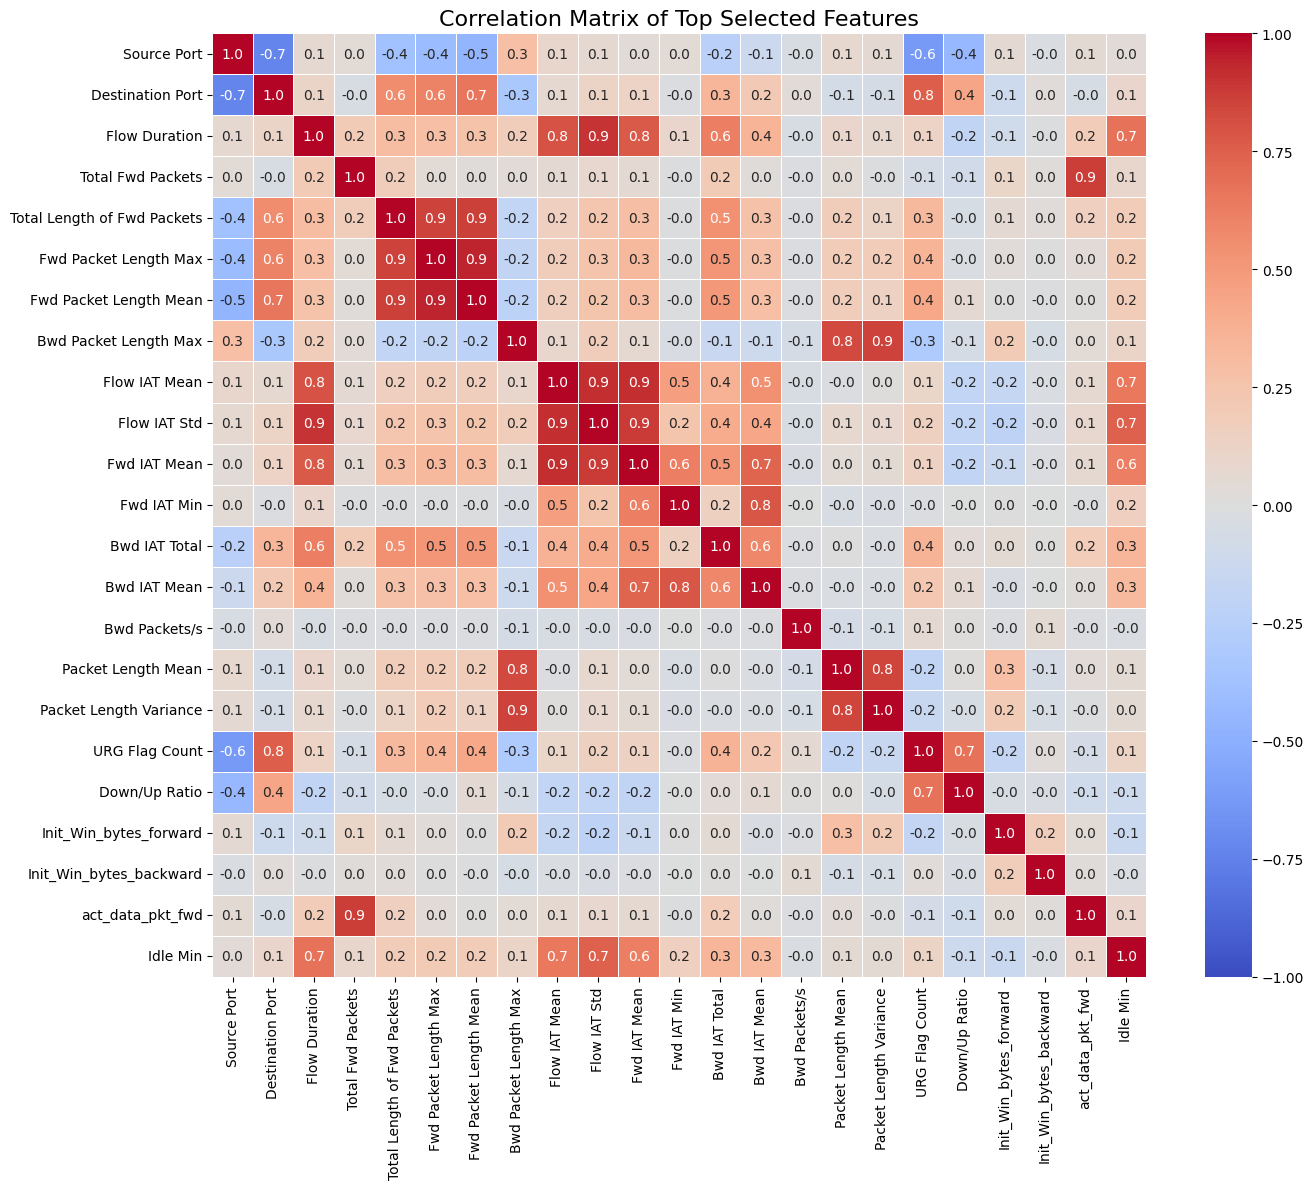

[OK] clear_correlation_matrix.png saved
Generating Selected Features Correlation Matrix


In [12]:


#(Selected Features)
selected_columns = X_train.columns[rfecv.support_] 
X_train_selected = X_train[selected_columns]

plt.figure(figsize=(14, 12))

corr_matrix_selected = X_train_selected.corr()

sns.heatmap(corr_matrix_selected, 
            annot=True,       
            fmt='.1f',        
            cmap='coolwarm',  
            vmin=-1, vmax=1,
            linewidths=0.5)  

plt.title('Correlation Matrix of Top Selected Features', fontsize=16)
plt.tight_layout()
plt.savefig('clear_correlation_matrix.png', dpi=300)
plt.show()

print("[OK] clear_correlation_matrix.png saved")
print("Generating Selected Features Correlation Matrix")


## 10. Save Final Dataset


In [13]:
print("\nSaving final dataset...")
final_cols = list(selected_features) + ['Label']
df_selected = df[final_cols]
df_selected.to_csv("selected_features_dataset.csv")
print("Done. Saved to selected_features_dataset.csv")




Saving final dataset...
Done. Saved to selected_features_dataset.csv
